# Model Training

## Prerequisites

To run this notebook the `data_path` variable has to point to the location of a valid dataset. If you don't have any data an example dataset can be obtained by characterizing [PTM](http://ptm.asu.edu/) transistor models as shown in [pyrdict](https://github.com/AugustUnderground/pyrdict).

Additionally, for training [precept](https://github.com/electronics-and-drives/precept) has to be installed manually.

## Setup

In [1]:
%matplotlib inline

In [2]:
import os
import torch
import h5py as h5
import numpy as np
import torch as pt
import pandas as pd
import joblib as jl
from datetime import datetime as dt
from functools import partial
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, minmax_scale

In [3]:
from pytorch_lightning import Trainer
from precept import PreceptModule, PreceptDataFrameModule

In [4]:
num_gpus = pt.cuda.device_count() if pt.cuda.is_available() else None

## Data

**Note**: This part has to be adjusted according to the location and shape of custom datasets.

- Adjust `data_path` accordingly, so it points to a your $\frac{g_{\mathrm{m}}}{I_{\mathrm{d}}}$ look up table.
- Depending on the shape of the dataset and file format it may need to be read differently.

If the data is generated with [pyrdict](https://github.com/AugustUnderground/pyrdict) the resulting `h5` is structured such that each parameter is a group.

In [5]:
device_type = "nmos"
device_tech = "90nm"
device_name = "ptm"
data_path   = f"../data/{device_tech}_bulk_{device_type}.h5"

In [6]:
with h5.File(data_path, "r") as data_base:
    column_names = list(data_base.keys())
    data_matrix  = np.transpose(np.array([data_base[c] for c in column_names]))
    data_frame   = pd.DataFrame(data_matrix, columns=column_names).dropna()

### Preprocesing and Filtering

Only the data necessary for preprocessing and the function mappings is kept, everything else can be filtered out.

In [7]:
params   = [ "Vgs", "Vds", "Vbs", "L", "W"
           , "gmid", "fug", "vdsat", "a0" , "jd" ]
data_raw = data_frame[params]

Since in the vast majority of cases a device is desired to be in saturation all other cases are filtered out.

In [8]:
data_filtered = data_raw[ ( (round(data_raw.Vgs, 2) == round(data_raw.Vds, 2))
                          & (round(data_raw.Vbs, 2) == 0.0) ) ].sample(frac=1)
data_filtered.describe()

,Vgs,Vds,Vbs,L,W,gmid,fug,vdsat,a0,jd
count,12000.000000,12000.000000,1.200000e+04,1.200000e+04,12000.000000,12000.000000,1.200000e+04,12000.000000,12000.000000,12000.000000
mean,0.604996,0.605000,1.884947e-09,5.075000e-06,0.000038,11.808862,6.373879e+09,0.252601,308.244980,30.768023
std,0.346407,0.346413,8.248914e-09,3.143683e-06,0.000024,9.290189,2.246291e+10,0.202380,186.578643,97.822973
min,0.010000,0.010000,2.476240e-14,1.500000e-07,0.000001,1.401889,3.244685e+02,0.041946,0.312317,0.000003
25%,0.307500,0.307500,6.005340e-13,2.338889e-06,0.000017,3.105811,7.796681e+06,0.049041,164.454844,0.049548
50%,0.604999,0.605000,1.439768e-12,5.075000e-06,0.000038,7.858961,3.909275e+07,0.204440,317.337422,3.707327
75%,0.902496,0.902500,7.095195e-11,7.811111e-06,0.000059,21.654469,1.896288e+08,0.424193,447.212435,15.572125
max,1.200000,1.200000,1.379620e-07,1.000000e-05,0.000075,26.747244,9.781450e+10,0.671238,675.289040,718.151416


### Mappings

For each device ($\delta \in [\mathrm{"NMOS"}, \mathrm{"PMOS"}]$) and 
technology ($\tau = 90\,\mathrm{nm}$ in this case) the mapping $\gamma$ is trained

$$\gamma_{\mathrm{\delta,\tau}} = 
    \begin{bmatrix} 
        \frac{g_{\mathrm{m}}}{I_{\mathrm{d}}} \\ f_{\mathrm{ug}} 
    \end{bmatrix} 
    \mapsto
    \begin{bmatrix}
        J_{\mathrm{d}} \\ L \\ A_{0}
    \end{bmatrix},$$

where $A_{0} = \frac{g_{\mathrm{m}}}{g_{\mathrm{ds}}}$ and $J_{\mathrm{d}} = \frac{I_{\mathrm{d}}}{W}$.

The model converges better when $f_{\mathrm{ug}}$ and $J_{\mathrm{d}}$ are trained on the $\log_{10}$ instead.

In [9]:
transformed_x = np.vstack([ data_filtered.gmid.values
                          , np.log10(data_filtered.fug.values)]).T
transformed_y = np.vstack([ np.log10(data_filtered.jd.values)
                          , data_filtered.L.values
                          , data_filtered.a0.values ]).T

Additionally, the data is scaled such that each parameter is $\in [0;1]$.

In [10]:
scale_x     = MinMaxScaler()
scale_y     = MinMaxScaler()

scaled_x    = scale_x.fit_transform(transformed_x).T
scaled_y    = scale_y.fit_transform(transformed_y).T

## Training 

The batch size is deliberatly chosen to be small, based on experience with other datasets but may be increased at will. Same goes for the number of epochs.

In [11]:
batch_size = 2000
test_split = 0.2
num_epochs = 42
params_x = ["gmid", "fug"]
params_y = ["jd", "L", "a0"]

In [12]:
data_scaled = pd.DataFrame( np.vstack((scaled_x, scaled_y)).T
                          , columns = (params_x + params_y) )

A folder for storing the model will be dynamically created in the root of this repositry each time the notebook is run.
All trained models will be located under `models/custom/` and assigned with a timestamp.

In [13]:
time_stamp = dt.now().strftime("%Y-%m%d-%H%M%S")
model_dir  = f"../models/custom/{device_tech}-{device_name}-{time_stamp}/"
os.makedirs(model_dir, exist_ok = True)
model_prefix = f"{model_dir}/v-{device_type}-{device_tech}"

The data module handles loading and preparing the dataset for training.

In [14]:
data = PreceptDataFrameModule( data_scaled             # unecessary columns are filtered out internally
                             , params_x, params_y      # input and output parameters
                             , [], [], [], []          # No transformations
                             , batch_size = batch_size
                             , test_split = test_split
                             , scale      = False      # No need to scale data, we did that before
                             , )

The lightning module prepares the Neural Network.

In [15]:
module = PreceptModule( len(params_x), len(params_y)
                      , model_path = model_dir
                      , )

The Trainier handles training, logging and periodic checkpoint saving of the model.

In [16]:
trainer     = Trainer( gpus                = num_gpus
                     , max_epochs          = num_epochs
                     , precision           = 64
                     , checkpoint_callback = True
                     , default_root_dir    = model_dir
                     , )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Use the trainer to fit the module on the given data.

In [17]:
trainer.fit(module, data)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.4 M 
------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
11.038    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Save the best model and scalers for later use in circuit sizing.

In [18]:
trainer.save_checkpoint(f"{model_prefix}.ckpt")
jl.dump(scale_x, f"{model_prefix}.X")
jl.dump(scale_y, f"{model_prefix}.Y")

['../models/custom/90nm-ptm-2021-0628-095919//v-nmos-90nm.Y']

## Evaluation

The model is evaluated by plotting a trace vs. the ground truth of the data base. First, the model and normalizers are loaded from disk, then
a `predict` function is defined that takes in a `DataFrame` with columns $\frac{g_{\mathrm{m}}}{I_{\mathrm{d}}}$ and $f_{\mathrm{ug}}$ and returns a `DataFrame` object with columns $J_{\mathrm{d}}$, $L$ and $A_{0}$.

In [19]:
nmos90 = PreceptModule.load_from_checkpoint(f"{model_prefix}.ckpt")
nmos90.cpu()
nmos90.eval()

PreceptModule(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=256, bias=True)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): ReLU()
    (14): Linear(in_features=128, out_features=3, bias=True)
    (15): ReLU()
  )
)

In [20]:
# predict :: DataFame -> DataFrame
def predict(X):
    with pt.no_grad():
        X_ = scale_x.transform(np.vstack([ X.gmid.values
                                         , np.log10(X.fug.values)]).T)
        Y_ = nmos90(pt.from_numpy(np.float32(X_))).numpy()
        Y  = pd.DataFrame( scale_y.inverse_transform(Y_)
                         , columns=params_y )
        Y.jd = np.power(10, Y.jd.values)
    return pd.DataFrame(Y, columns=params_y)

For the ground truth, a random _width_ $W$ and _length_ $L$ are chosen as.

In [21]:
trace_tru = data_raw[ ( (data_raw.W == np.random.choice(data_raw.W.unique()))
                      & (data_raw.L == np.random.choice(data_raw.L.unique()))
                      & (round(data_raw.Vgs, 2) == round(data_raw.Vds, 2))
                      & (round(data_raw.Vbs, 2) == 0.0)) ].sort_values(by="gmid").dropna()

In [22]:
trace_prd = predict(trace_tru[params_x])

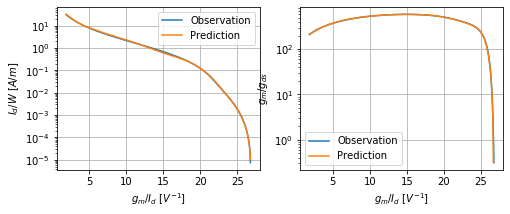

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
ax1.plot(trace_tru.gmid.values, trace_tru.jd.values, label="Observation")
ax1.plot(trace_tru.gmid.values, trace_prd.jd.values, label="Prediction")
ax1.set_yscale("log")
ax1.set_xlabel("$g_{m} / I_{d} ~ [V^{-1}]$")
ax1.set_ylabel("$I_{d} / W ~ [A/m]$")
ax1.legend()
ax1.grid("on")
ax2.plot(trace_tru.gmid.values, trace_tru.a0.values, label="Observation")
ax2.plot(trace_tru.gmid.values, trace_prd.a0.values, label="Prediction")
ax2.set_yscale("log")
ax2.set_xlabel("$g_{m} / I_{d} ~ [V^{-1}]$")
ax2.set_ylabel("$g_{m} / g_{ds}$")
ax2.legend()
ax2.grid("on")

The resulting model shows how well the predictions agree with the ground truth.